# Assignment 4, by Maksim Kaledin

## Sub-problem 1

Let $b_j$ be the coordinate of $j$-th beacon, $w_i$ be the location of waypoint number $i$. Reconstruction problem could be formulated as LS problem with residuals $b_j-w_i-d_{ij}$, where $d_{ij}$ is the displacement of beacon $i$ w.r.to waypoint $i$. So we get the following minimization problem:

$$
\min_{\mathbf{w},\mathbf{b}} \sum_{i \in W} \sum_{j \in N(i)} \Vert b_j-w_i-d_{ij} \Vert,
$$

here $W$ denotes set of waypoints and $N(i)$ stands for "neigbourhood", the set of beacons sensed in waypoint $i$.

To solve this one way is to construct the normal equations, its solution will be an optimum since the goal function $F$ is convex.

$$
\begin{split}
\frac{\partial F}{\partial b_j}= \sum_{i \in W: j \in N(i)} 2(b_j-w_i-d_{ij}),\\
\frac{\partial F}{\partial w_i}= \sum_{j \in N(i)} -2(b_j-w_i-d_{ij})
\end{split}
$$

is a system of linear equations, so we construct the matrix $A$, right part $\mathbf{f}$, and solve

$$
A
\begin{bmatrix}
\mathbf{b}\\
\mathbf{w}
\end{bmatrix}=\mathbf{f}.
$$


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [401]:
def construct_linsyst(ws,bs,ds_x,ds_y):

    beacs_inds = np.sort(np.unique(bs))
    ws_inds = np.unique(ws)
    
    n=ws_inds.shape[0]
    m=beacs_inds.shape[0]
    
    A=np.zeros((2*(n+m),2*(n+m)))
    f=np.zeros((2*(n+m),1))
    #construct the first set of eqs vector is b_00 b_01, b_10 b_11 ,...
    for j in beacs_inds:
        j_ind = np.where(bs==j)
        w_ind = np.unique(ws[j_ind])
        A[2*(j-1),2*(m+w_ind-1)]=-1 #set coef before w_i
        A[2*(j-1)+1,2*(m+w_ind-1)+1]=-1
        
        A[2*(j-1),2*(j-1)]=w_ind.shape[0]
        A[2*(j-1)+1,2*(j-1)+1]=w_ind.shape[0]
        
        f[2*(j-1)]=np.sum(ds_x[j_ind])
        f[2*(j-1)+1]=np.sum(ds_y[j_ind])
        
    #the second one
    for i in ws_inds:
        b_ind=np.unique(bs[np.where(ws==i)])
        
        A[2*m+2*(i-1),2*(b_ind-1)]=1#set coef before b_i
        A[2*m+2*(i-1)+1,2*(b_ind-1)+1]=1
        
        A[2*m+2*(i-1),2*m+2*(i-1)]=-b_ind.shape[0]
        A[2*m+2*(i-1)+1,2*m+2*(i-1)+1]=-b_ind.shape[0]
        
        w_ind=np.where(ws==i)
        f[2*m+2*(i-1)]=np.sum(ds_x[w_ind])
        f[2*m+2*(i-1)+1]=np.sum(ds_y[w_ind])
        
    A=A[2:,2:]#set b1=0
    f=f[2:]
    return (A,f)



In [402]:
import scipy.io as sio

task1_contents = sio.loadmat('task1.mat')

beacs_1 = task1_contents['beacons']
robots_1 = task1_contents['robots']
x_1 = task1_contents['x']
y_1 = task1_contents['y']

n=np.unique(robots_1).shape[0]
m=np.unique(beacs_1).shape[0]

    
(A,f) = construct_linsyst(robots_1,beacs_1,x_1,y_1)



In [399]:
import scipy.linalg as splin

print(np.linalg.cond(A))
sol = splin.solve(A,f)


133.89029031


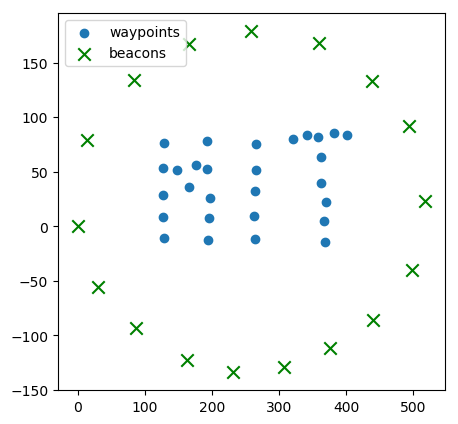

In [400]:
waypoints_x = np.array(sol[np.arange(2*m-2,2*m+2*n-2,2),0])
waypoints_y = np.array(sol[np.arange(2*m+1-2,2*m+2*n-2,2),0])

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],np.array(sol[np.arange(0,2*m-2,2),0])])
beacons_y = np.concatenate([[0],np.array(sol[np.arange(1,2*m-2,2),0])])
#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

Let us check what happens if we use matrix inverse.

In [403]:
task1_contents = sio.loadmat('task1.mat')

beacs_1 = task1_contents['beacons']
robots_1 = task1_contents['robots']
x_1 = task1_contents['x']
y_1 = task1_contents['y']

n=np.unique(robots_1).shape[0]
m=np.unique(beacs_1).shape[0]

    
(A,f) = construct_linsyst(robots_1,beacs_1,x_1,y_1)

In [405]:
print(np.linalg.cond(A))
sol = splin.inv(A).dot(f)

133.89029031


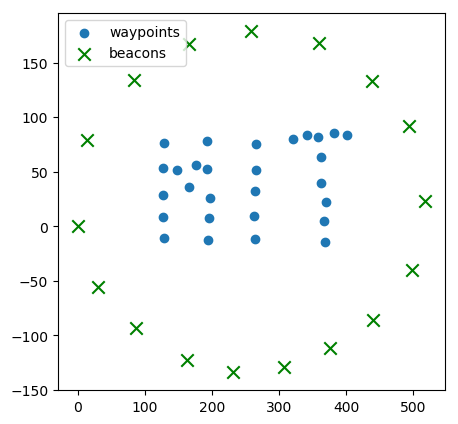

In [406]:
waypoints_x = np.array(sol[np.arange(2*m-2,2*m+2*n-2,2),0])
waypoints_y = np.array(sol[np.arange(2*m+1-2,2*m+2*n-2,2),0])

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],np.array(sol[np.arange(0,2*m-2,2),0])])
beacons_y = np.concatenate([[0],np.array(sol[np.arange(1,2*m-2,2),0])])
#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

So the matrix is quite good and with small condition number. So inverse matrix can be computed accurately and produce the same solution. Note that it is not the case if we haven't fixed one of the points above. If we haven't, then matrix is singular and there is a continuum of solutions which differ only by translation.

## Sub-problem 2

We are in the same setting, however now we need also to consider error in orientation. Depending on robot orientation, the points around it could be rotated around robot's position. This rotation can be set as the composition of translation-rotation-translation. Let $r_{ij}$ be the residual on observation with beacon $b_i$ and waypoint $w_j$, $b_i,w_j$ denote coordinates of beacon and robot respectively. Rotation operator could be expressed as
$$
Rotate(\theta,w_j)(x)=R_\theta(x-w_j)+w_j,
$$
where $R_\theta$ is a standard 2D rotation operator. Applying rotation to beacon position gives an expression for residual

$$
r_{ij}=R_\theta(b_i-w_j)+w_j-w_j-d_{ij}=R_\theta(b_i-w_j)-d_{ij}.
$$

If beacon $i$ is not sensed in waypoint $j$ then $r_{ij}=0$. The overall problem is to minimize the 2-norm of the residual vector 

$$
\min_{\mathbf{b},\mathbf{w},\mathbf{\theta}}{\Vert \mathbf{r} \Vert_2^2},
$$

where $\mathbf{r}$ is a column vector consisting of 2d subcolumns $r_{ij}$ defined above.

### Jacobian expression

Jacobian is not so hard to derive analytically. Consider first Jacobian matrix for one residual $r_{ij}$ and let there be only variables corresponding to this residual: $b_i,w_j,\theta_i$. Then 

$$
\mathbf{J}_{b_i,w_j,\theta_i}(r_{ij})=
\begin{bmatrix}
R_{\theta_i} &\vert& -R_{\theta_i} &\vert& R'_{\theta_i}(b_i-w_j)
\end{bmatrix},
$$
where $R'_{theta_i}$ is matrix which is got from differentiation by $\theta_i$:

$$
R'_{\theta_i}=
\begin{bmatrix}
-\sin{\theta_i} & -\cos{\theta_i}\\
\cos{\theta_i} & -\sin{\theta_i}
\end{bmatrix}.
$$

To build Jacobian of $\mathbf{r}$ we need to embed this structure in big matrix $2K \times 2(m+n)+n-2$, where $K$ is the number of observations (2K if we separate $x,y$ coordinates), $m$ is the number of beacons and $n$ is the number of waypoints. The overall number of variables is $2n$ for waypoints + $2(m-1)$ for beacons + $n$ for orientations. For all residual we separate the small Jacobian matrix into three mentioned submatrices and insert them in corresponding columns. Other columns should be assigned to zero.

### Different rotations

Suppose we obtained some optimal solution. Obviously, if we rotate it somehow (axis does not matter), the distances are the same. Because of this conservation property, there are infinitely many solutions which are different only by rotation.

In [377]:
def R(theta):
    #generates rotation matrix, angle=theta
    return np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta), np.cos(theta)]])

def R_prime(theta):
    #generates a theta-derivative of rotation matrix, angle=theta
    return np.array([[-np.sin(theta), -np.cos(theta)],[np.cos(theta), -np.sin(theta)]])

def computeJacobian(x,dxs,dys,beacs,ways): #x is a vector of all variables: b,w,thetas
    
    #compute jacobian matrix
    beac_number = np.unique(beacs).shape[0]-1 #throw away beacon 0
    wayp_number = np.unique(ways).shape[0]
    
    Jac= np.zeros((2*dxs.shape[0],x.shape[0]))
    for res_ind in np.arange(dxs.shape[0]):
        curBeac = beacs[res_ind][0]-2
        curWay = ways[res_ind][0]-1
        
        wj_ind = 2*(curWay+beac_number)
        thetai_ind = 2*wayp_number+2*beac_number+curWay
        if(curBeac>=0):
            if(thetai_ind<2*beac_number+2*wayp_number+wayp_number-1):
                #if we are not in last theta=0
                #theta derivative
                Jac[(2*res_ind):(2*res_ind+2),thetai_ind]=R_prime(x[thetai_ind]).dot(x[(2*curBeac):(2*(curBeac)+2)]-x[wj_ind:(wj_ind+2)])
            
                #b derivative
                Jac[(2*res_ind):(2*res_ind+2),(2*(curBeac)):(2*(curBeac)+2)]=R(x[thetai_ind])
        
                #w derivative
                Jac[(2*res_ind):(2*res_ind+2),(wj_ind):(wj_ind+2)]=-R(x[thetai_ind])
            else:
                #if we are there                
            
                #b derivative
                Jac[(2*res_ind):(2*res_ind+2),(2*(curBeac)):(2*(curBeac)+2)]=np.eye(2)
        
                #w derivative
                Jac[(2*res_ind):(2*res_ind+2),(wj_ind):(wj_ind+2)]=-np.eye(2)
        else:
            if(thetai_ind<2*beac_number+2*wayp_number+wayp_number-1):
                #the same stuff as above
                #theta derivative
                Jac[(2*res_ind):(2*res_ind+2),thetai_ind]=R_prime(x[thetai_ind]).dot(-x[wj_ind:(wj_ind+2)])
        
                #w derivative
                Jac[(2*res_ind):(2*res_ind+2),(wj_ind):(wj_ind+2)]=-R(x[thetai_ind])
            else:
                #w derivative
                Jac[(2*res_ind):(2*res_ind+2),(wj_ind):(wj_ind+2)]=-np.eye(2)
    
    return Jac

def computeResiduals(x,dxs,dys,beacs,ways):
    beac_number = np.unique(beacs).shape[0]-1#throw away beacon 0
    wayp_number = np.unique(ways).shape[0]
    
    resid_number=dxs.shape[0]
    resids=np.zeros(2*resid_number)
    
    for res_ind in np.arange(resid_number):
        curBeac = beacs[res_ind][0]-2
        curWay = ways[res_ind][0]-1
        
        wj_ind = 2*(curWay+beac_number)
        thetai_ind = 2*wayp_number+2*beac_number+curWay
        
        if(curBeac>=0):
            if(thetai_ind<2*beac_number+2*wayp_number+wayp_number-1):
                part_res=R(x[thetai_ind]).dot(x[(2*(curBeac)):(2*(curBeac)+2)]-x[wj_ind:((wj_ind+2))])
            else:
                part_res=x[(2*(curBeac)):(2*(curBeac)+2)]-x[wj_ind:((wj_ind+2))]
        else:
            if(thetai_ind<2*beac_number+2*wayp_number+wayp_number-1):
                part_res=R(x[thetai_ind]).dot(-x[wj_ind:(wj_ind+2)])
            else:
                part_res=-x[wj_ind:(wj_ind+2)]
        
        resids[(2*res_ind):(2*res_ind+2)]=part_res-np.array([dxs[res_ind][0],dys[res_ind][0]])

    return resids


In [378]:
#Compute initial guess
import scipy.io as sio

task1_contents = sio.loadmat('task2.mat')

beacs_2 = task1_contents['beacons']
robots_2 = task1_contents['robots']
x_2 = task1_contents['x']
y_2 = task1_contents['y']

n=np.unique(robots_2).shape[0]
m=np.unique(beacs_2).shape[0]

    
(A,f) = construct_linsyst(robots_2,beacs_2,x_2,y_2)



In [379]:
import scipy.linalg as splin

print(np.linalg.cond(A))
sol = splin.solve(A,f)

1581.62372385


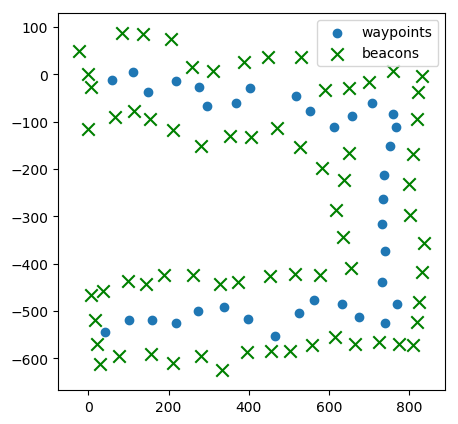

In [380]:
waypoints_x = np.array(sol[np.arange(2*m-2,2*m+2*n-2,2),0])
waypoints_y = np.array(sol[np.arange(2*m+1-2,2*m+2*n-2,2),0])

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],np.array(sol[np.arange(0,2*m-2,2),0])])
beacons_y = np.concatenate([[0],np.array(sol[np.arange(1,2*m-2,2),0])])
#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

This is a very rough guess, however it is quite good. Now let us initialize rotations to be zero and launch Levenberg-Marquardt algorithm.

In [381]:
#solution is bs,ws,thetas

beacs=np.zeros((2*beacons_x.shape[0]-2,))
beacs[np.arange(0,2*beacons_x.shape[0]-2,2)]=beacons_x[1:]
beacs[np.arange(1,2*beacons_x.shape[0]-2,2)]=beacons_y[1:]

waypoints=np.zeros((2*waypoints_x.shape[0],))
waypoints[np.arange(0,2*waypoints_x.shape[0],2)]=waypoints_x
waypoints[np.arange(1,2*waypoints_x.shape[0]+1,2)]=waypoints_y

x0 = np.concatenate([beacs,waypoints,np.zeros(waypoints_x.shape[0]-1)]) #init rotations to zero
#-1 for the last rotation which is fixed to be zero

In [382]:
import scipy.optimize as sciopt

opt_res = sciopt.least_squares(computeResiduals,x0,computeJacobian,args=(x_2,y_2,beacs_2,robots_2),method="lm")
print(opt_res.message)
print(opt_res.success)

`ftol` termination condition is satisfied.
True


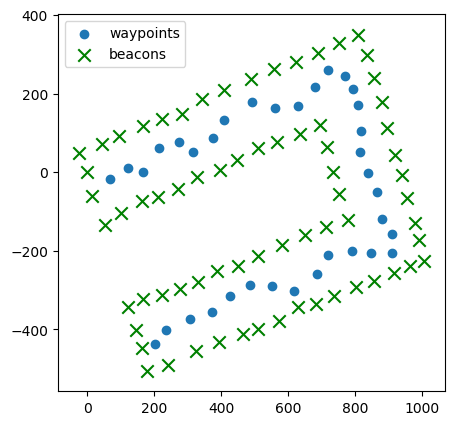

In [384]:

waypoints_x = opt_res.x[np.arange(2*m-2,2*m+2*n-2,2)]
waypoints_y = opt_res.x[np.arange(2*m+1-2,2*m+2*n-2,2)]

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],opt_res.x[np.arange(0,2*m-2,2)]])
beacons_y = np.concatenate([[0],opt_res.x[np.arange(1,2*m-2,2)]])

#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])



## Sub-problem 3

Let us apply the same algorithm to new data.

In [385]:
#Compute initial guess
import scipy.io as sio

task1_contents = sio.loadmat('task3.mat')

beacs_3 = task1_contents['beacons']
robots_3 = task1_contents['robots']
x_3 = task1_contents['x']
y_3 = task1_contents['y']

n=np.unique(robots_3).shape[0]
m=np.unique(beacs_3).shape[0]

    
(A,f) = construct_linsyst(robots_3,beacs_3,x_3,y_3)

In [386]:
import scipy.linalg as splin

print(np.linalg.cond(A))
sol = splin.solve(A,f)

542.212162852


Сompute initial guess.

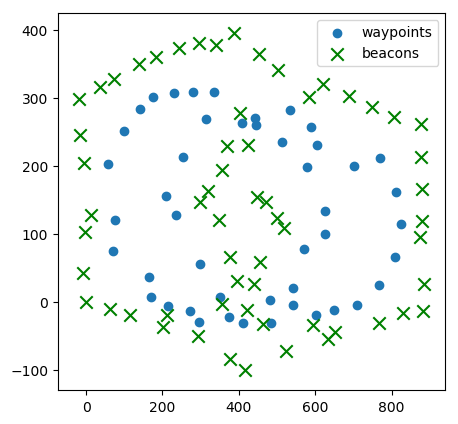

In [387]:
waypoints_x = np.array(sol[np.arange(2*m-2,2*m+2*n-2,2),0])
waypoints_y = np.array(sol[np.arange(2*m+1-2,2*m+2*n-2,2),0])

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],np.array(sol[np.arange(0,2*m-2,2),0])])
beacons_y = np.concatenate([[0],np.array(sol[np.arange(1,2*m-2,2),0])])
#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

In [388]:
#solution is bs,ws,thetas

beacs=np.zeros((2*beacons_x.shape[0]-2,))
beacs[np.arange(0,2*beacons_x.shape[0]-2,2)]=beacons_x[1:]
beacs[np.arange(1,2*beacons_x.shape[0]-2,2)]=beacons_y[1:]

waypoints=np.zeros((2*waypoints_x.shape[0],))
waypoints[np.arange(0,2*waypoints_x.shape[0],2)]=waypoints_x
waypoints[np.arange(1,2*waypoints_x.shape[0]+1,2)]=waypoints_y

x0 = np.concatenate([beacs,waypoints,np.zeros(waypoints_x.shape[0]-1)]) #init rotations to zero
#-1 for the last rotation which is fixed to be zero

Now use it with usual non-linear least squares.

In [395]:
import scipy.optimize as sciopt

opt_res = sciopt.least_squares(computeResiduals,x0,computeJacobian,args=(x_3,y_3,beacs_3,robots_3),method="lm")
print(opt_res.message)
print(opt_res.success)

`ftol` termination condition is satisfied.
True


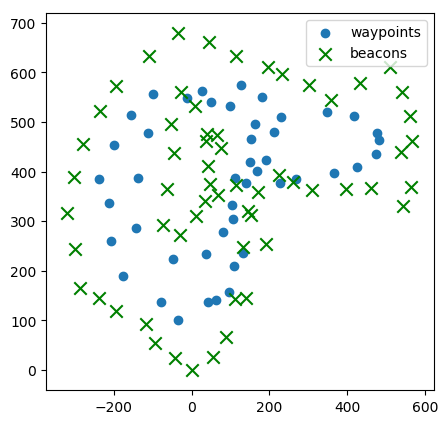

In [396]:
waypoints_x = opt_res.x[np.arange(2*m-2,2*m+2*n-2,2)]
waypoints_y = opt_res.x[np.arange(2*m+1-2,2*m+2*n-2,2)]

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],opt_res.x[np.arange(0,2*m-2,2)]])
beacons_y = np.concatenate([[0],opt_res.x[np.arange(1,2*m-2,2)]])

#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])


The reconstrunction does not seem like any usual indoor environment. But we can significantly increase quality bu introducing other loss function. Let us experiment with some of them.

### Huber loss function
It is defined as

$$
\rho(z) = \begin{cases}
z, \quad \text{if $z <= 1$},\\
2z^{0.5} - 1, \quad \text{otherwise}.
\end{cases}
$$

This function gives usual absolute value if residual is small and pays much less attention to larger ones. So outliers can be effectively wiped out and moreover, the problem is more robust to noises.

In [391]:
import scipy.optimize as sciopt

opt_res = sciopt.least_squares(computeResiduals,x0,computeJacobian,args=(x_3,y_3,beacs_3,robots_3),loss="huber")
print(opt_res.message)
print(opt_res.success)

`ftol` termination condition is satisfied.
True


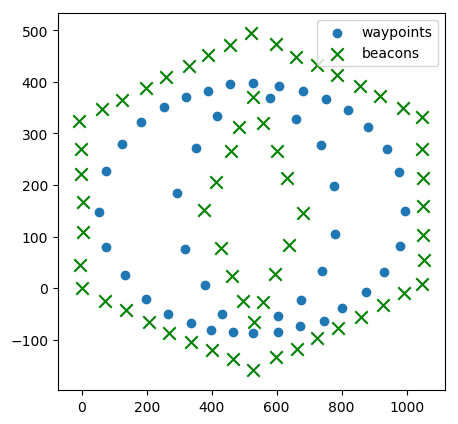

In [392]:
waypoints_x = opt_res.x[np.arange(2*m-2,2*m+2*n-2,2)]
waypoints_y = opt_res.x[np.arange(2*m+1-2,2*m+2*n-2,2)]

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],opt_res.x[np.arange(0,2*m-2,2)]])
beacons_y = np.concatenate([[0],opt_res.x[np.arange(1,2*m-2,2)]])

#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

Looks quite structured.

### Soft_l1

This is defined as
$$
rho(z) = 2 ((1 + z)^{0.5} - 1).
$$

In the neigbourhood of zero it is like an absolute value but again pays less to outliers.

In [393]:
import scipy.optimize as sciopt

opt_res = sciopt.least_squares(computeResiduals,x0,computeJacobian,args=(x_3,y_3,beacs_3,robots_3),loss="soft_l1")
print(opt_res.message)
print(opt_res.success)

`ftol` termination condition is satisfied.
True


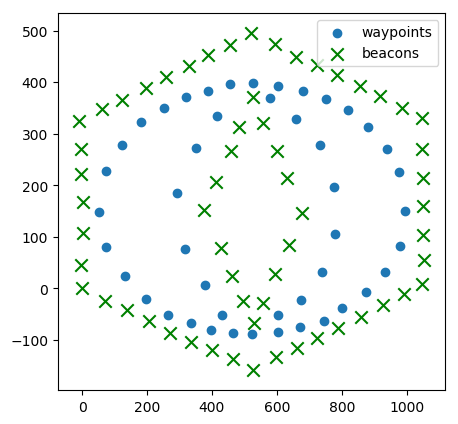

In [394]:
waypoints_x = opt_res.x[np.arange(2*m-2,2*m+2*n-2,2)]
waypoints_y = opt_res.x[np.arange(2*m+1-2,2*m+2*n-2,2)]

#print(waypoints_x,waypoints_y)
beacons_x = np.concatenate([[0],opt_res.x[np.arange(0,2*m-2,2)]])
beacons_y = np.concatenate([[0],opt_res.x[np.arange(1,2*m-2,2)]])

#print(beacons_x,beacons_y)
f, ax = plt.subplots(figsize=(5,5))

plt1 = ax.scatter(waypoints_x,waypoints_y)
plt2 = ax.scatter(beacons_x,beacons_y,marker='x',c='green',s=80)
ax.legend([plt1,plt2],["waypoints","beacons"])

Also looks good enough.